**Arshia YousefiNezhad**

student number : 610302085

Task 5 Machine Learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Question 1**

in this code I reading train and test csv file
and also I seprate train and test categorical and numerical data. finally I using StandardScaler for normalize numerical data


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

train_set = pd.read_csv('/content/drive/MyDrive/University_of_Tehran/Exercise5/train_set.csv')
test_set = pd.read_csv('/content/drive/MyDrive/University_of_Tehran/Exercise5/test_set.csv')

categorical = [var for var in train_set.columns if train_set[var].dtype=='O']
categorical.remove('income')
numerical = [var for var in train_set.columns if train_set[var].dtype!='O']

X_train_num = train_set[numerical]
X_train_cat = train_set[categorical]
y_train = train_set['income']

X_test_num = test_set[numerical]
X_test_cat = test_set[categorical]

### Normalized Numerical data

In [ ]:
standard_scaler = StandardScaler()
X_train_num = standard_scaler.fit_transform(X_train_num)
X_test_num = standard_scaler.transform(X_test_num)

# Question 2

### One Hot Encoder
for linear model is better using onehot encoding. I use that and fitting and trasformed it on train and transformed on test data

In [ ]:
from sklearn.preprocessing import OneHotEncoder


enc = OneHotEncoder()

X_train_cat_encoded = enc.fit_transform(X_train_cat).toarray()
X_test_cat_encoded = enc.transform(X_test_cat).toarray()



### Label Encoder
I using label encoder to convert string data on target column


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

# Logistic Regression model
 I am using three loops to compute different parameters, similar to a grid search approach. I have set the learning rate to 'constant' and shuffle to 'False'. Based on what I observed in the SGDClassifier's parameters, the default values for the other parameters do not affect the training.

'log_loss' : cross entropy

finally I save best_model and its accuracy in some variables

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RepeatedKFold, GridSearchCV, cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Tuning this hyperparameters
learning_rate_list = [1, 1e-2, 1e-5]
regularization_term_list = [0, 1e-2, 1e-5]
max_iter_list = [500, 1000, 2000]

# using repeated Kfold to consider n_split and n_repeats
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

# concat Numerical and categorical train data
X_train_all = np.concatenate((X_train_num, X_train_cat_encoded), axis=1)

# Some initialization
parameters_scores = []
parameters_name = []
counter = 0
best_accuracy = 0
best_parameter = {}

# Three loop for tuning hyperparameters
for lr in learning_rate_list:
  for rg in regularization_term_list:
    for max_iter in max_iter_list:
      sgd_model = SGDClassifier(loss='log_loss', alpha=rg, max_iter=max_iter, shuffle=False, learning_rate='constant', random_state=42, eta0=lr)
      scores = cross_val_score(sgd_model, X_train_all, y_train, cv=rkf, scoring='accuracy')
      parameters_scores.append(scores)
      parameters_name.append(f"LR={lr}, Reg={rg}, MaxIter={max_iter}")
      counter+=1

      # Save best model and its accuracy
      if np.mean(scores) > best_accuracy:
                best_accuracy = np.mean(scores)
                best_model = sgd_model
                best_parameter['lr'] = lr
                best_parameter['rg'] = rg
                best_parameter['max_iter'] = max_iter


## Cross Validation Resualts

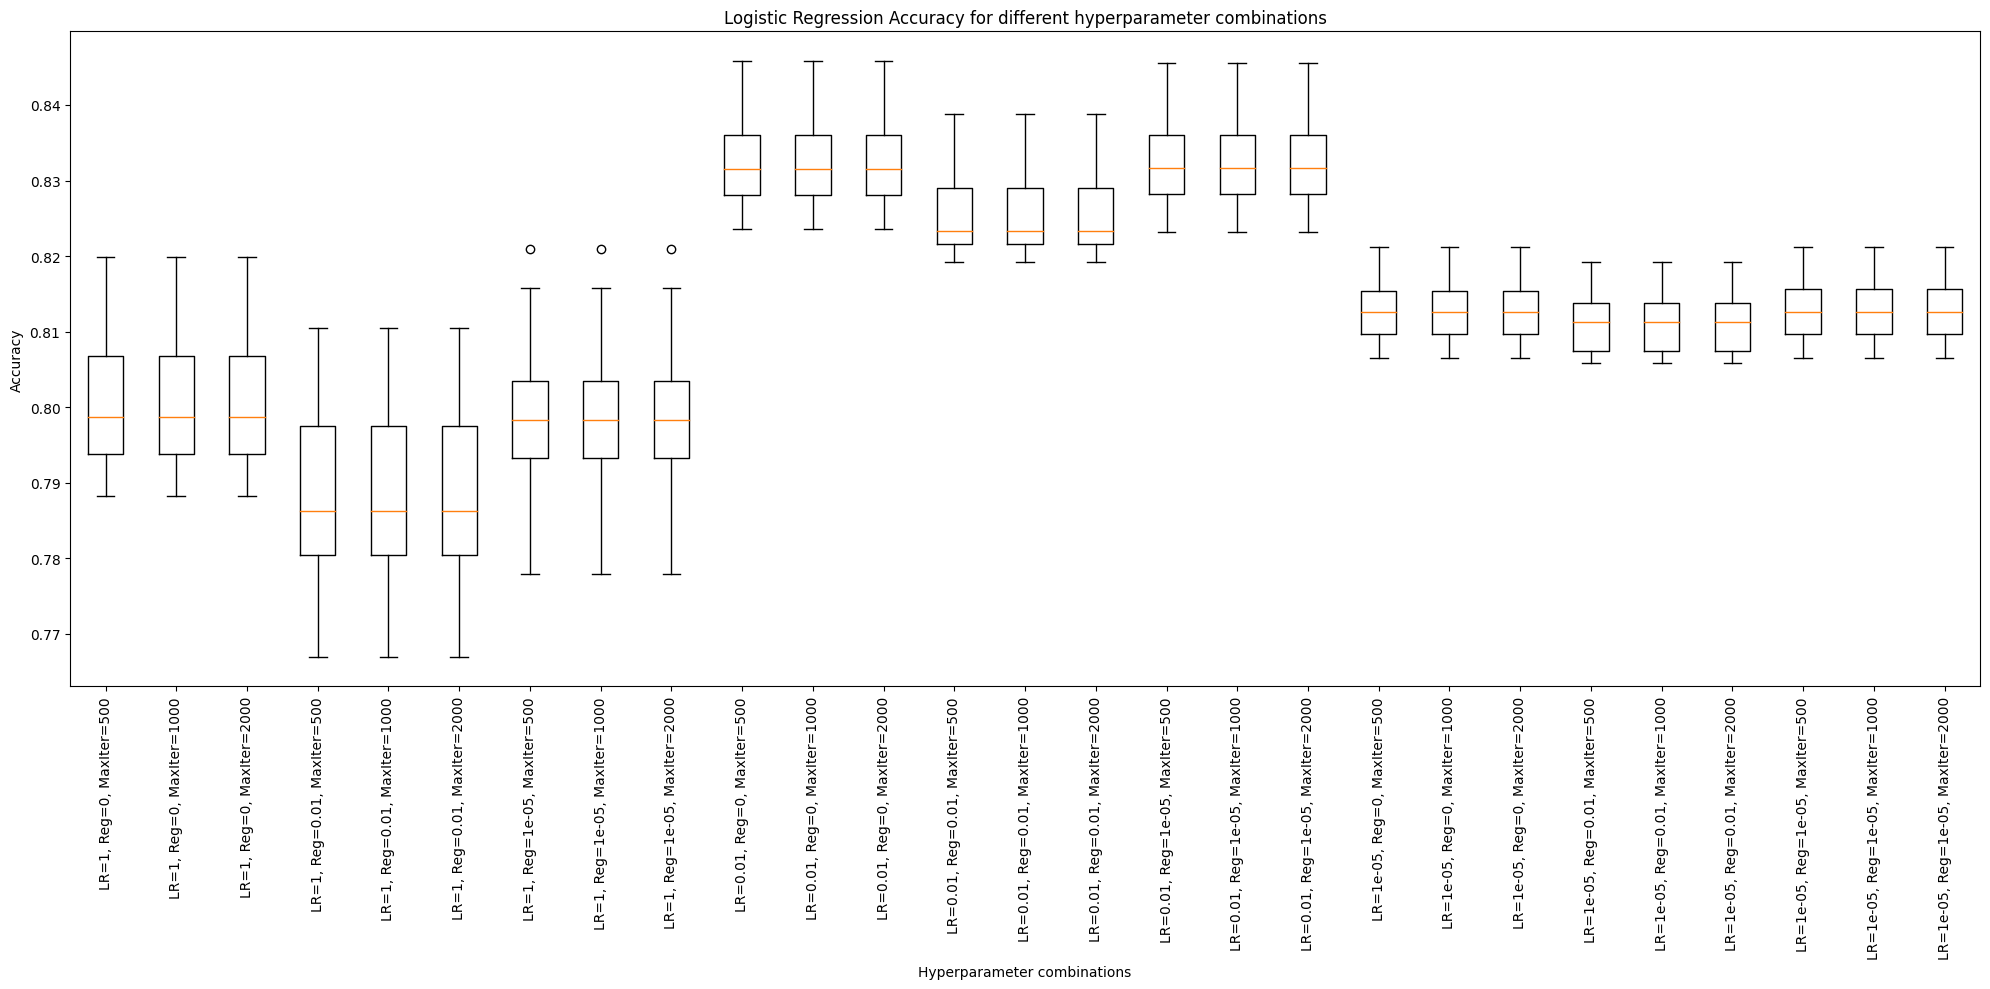

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.boxplot(parameters_scores, labels=parameters_name)
ax.set_title('Logistic Regression Accuracy for different hyperparameter combinations')
ax.set_xlabel('Hyperparameter combinations')
ax.set_ylabel('Accuracy')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Best logistic Regression model

In [ ]:
print(f'best accuracy score: {best_accuracy}')
print(f'best parameter score: {best_parameter}')

best accuracy score: 0.8325943427506608
best parameter score: {'lr': 0.01, 'rg': 0, 'max_iter': 500}


In [ ]:
finally_sgd_model = SGDClassifier(loss='log_loss', alpha=1e-06, max_iter=500, tol=1e-3, learning_rate='constant', random_state=42, eta0=1e-02)
score = cross_val_score(finally_sgd_model, X_train_all, y_train, cv=rkf, scoring='accuracy')
print(f'Cross Validation score: {np.mean(score)}')

Cross Validation score: 0.8327918555228455


## Prediction
For predict test data, first we need fitting data on train set and finally I
save prediction of the best model on csv file

In [ ]:
# concat Numerical and categorical test data
finally_sgd_model.fit(X_train_all, y_train)
X_test_all = np.concatenate((X_test_num, X_test_cat_encoded), axis=1)

prediction_sgd = finally_sgd_model.predict(X_train_all)

# Create a pandas Series
my_series = pd.Series(prediction_sgd, name='Prediction_sgd')

file_path = '/content/drive/MyDrive/University_of_Tehran/Exercise5/prediction_lr.csv'
my_series.to_csv(file_path, index=False)

# Naive Bayes Model

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

# Fitting a Gaussian Naive Bayes model on the continuous features
gnb = GaussianNB()
gnb.fit(X_train_num, y_train)
gaussian_probas = gnb.predict_proba(X_train_num)

# Fitting a Multinomial Naive Bayes model on the non-negative categorical features
mnb = MultinomialNB()
mnb.fit(X_train_cat_encoded, y_train)
multinomial_probas = mnb.predict_proba(X_train_cat_encoded)

# Stacking the class assignment probabilities to form new features
new_features = np.hstack((multinomial_probas, gaussian_probas))

# Defining a new Gaussian Naive Bayes model instance
new_gnb = GaussianNB()

# Fitting the new model on the new features
# new_gnb.fit(new_features, y_train)
scores = cross_val_score(new_gnb, new_features, y_train, cv=rkf, scoring='accuracy')



### Predication
we fitting new_gnb model on new_feature_train and y_train
and we follow training approach above. and then prediction on new_features_test

In [ ]:
multinomial_probas_train = mnb.predict_proba(X_train_cat_encoded)
gaussian_probas_train = gnb.predict_proba(X_train_num)
new_features_train = np.hstack((multinomial_probas_train, gaussian_probas_train))
new_gnb.fit(new_features_train, y_train)

multinomial_probas_test = mnb.predict_proba(X_test_cat_encoded)
gaussian_probas_test = gnb.predict_proba(X_test_num)
new_features_test = np.hstack((multinomial_probas_test, gaussian_probas_test))

predication_NB = new_gnb.predict(new_features_test)

In [ ]:
# Create a pandas Series
my_series = pd.Series(predication_NB, name='prediction_b')

file_path = '/content/drive/MyDrive/University_of_Tehran/Exercise5/prediction_b.csv'
my_series.to_csv(file_path, index=False)

In [ ]:
predication_NB[:20]

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0])

In [ ]:
prediction_sgd[:20]

array([0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])

# Campare Naive Bayes and SGDClassifier CV resualts

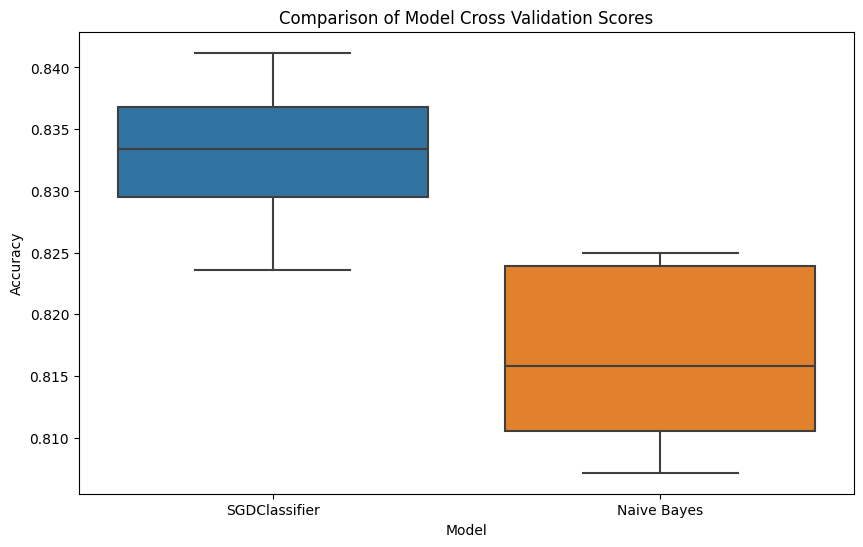

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sgd_scores = cross_val_score(finally_sgd_model, X_train_all, y_train, cv=rkf, scoring='accuracy')
nb_scores = cross_val_score(new_gnb, new_features, y_train, cv=rkf, scoring='accuracy')

# Creating a DataFrame with the scores
data = pd.DataFrame({
    "Score": np.concatenate([sgd_scores, nb_scores]),
    "Model": ["SGDClassifier"]*len(sgd_scores) + ["Naive Bayes"]*len(nb_scores)
})

# Creating the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Model", y="Score", data=data)
plt.title("Comparison of Model Cross Validation Scores")
plt.ylabel("Accuracy")
plt.show()
